In [ ]:
# Network Randomization: Configuration Model and Edge-Swapping
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.ticker as ticker
import urllib.request
import os

# Setting the random seed for reproducibility
np.random.seed(42)

## 1. Load and Prepare a Real-World Network

In [ ]:
# We'll use the arXiv HEP-TH (High Energy Physics Theory) citation network
# This network represents papers as nodes and citations as directed edges
# The network contains over 27,000 nodes (papers) and 350,000+ edges (citations)

def load_arxiv_network():
    """
    Load the arXiv HEP-TH citation network.
    Returns a directed graph.
    """
    # File name
    edges_file = "Datasets\cit-HepTh.txt\Cit-HepTh.txt"
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from the citation file
    with open(edges_file, 'r') as f:
        for line in f:
            # Skip comment lines starting with #
            if line.startswith('#'):
                continue
            # Parse the line
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = parts
                G.add_edge(source, target)
    
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

# Load the network
G_original = load_arxiv_network()

Loaded graph with 27770 nodes and 352807 edges


In [15]:

# Since this is a large network, let's work with a subgraph to make computation faster
# We'll extract a connected component with at least 1000 nodes

def get_subgraph(G, min_size=1000, max_size=4000):
    """
    Extract a connected subgraph with size between min_size and max_size nodes.
    If no component is within the size range, returns a subgraph of the largest component.
    """
    if not nx.is_directed(G):
        components = list(nx.connected_components(G))
    else:
        # For directed graphs, we convert to undirected for finding components
        G_undirected = G.to_undirected()
        components = list(nx.connected_components(G_undirected))
    
    # Sort components by size (largest first)
    components.sort(key=len, reverse=True)
    
    # Take the largest component that has at least min_size nodes
    for component in components:
        if min_size <= len(component) <= max_size:
            subgraph = G.subgraph(component).copy()
            return subgraph
    
    # If no component is in the desired range, take a subset of the largest component
    largest_component = list(components[0])
    if len(largest_component) > max_size:
        # Randomly select max_size nodes from the largest component
        selected_nodes = np.random.choice(largest_component, size=max_size, replace=False)
        subgraph = G.subgraph(selected_nodes).copy()
        
        # Ensure the subgraph is connected (if directed, check if weakly connected)
        if nx.is_directed(G):
            if not nx.is_weakly_connected(subgraph):
                # If not connected, find the largest connected component
                subgraph_undirected = subgraph.to_undirected()
                largest_cc = max(nx.connected_components(subgraph_undirected), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        else:
            if not nx.is_connected(subgraph):
                largest_cc = max(nx.connected_components(subgraph), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        
        return subgraph
    else:
        # Return the largest component if it's smaller than max_size
        return G.subgraph(largest_component).copy()

# Extract a subgraph of reasonable size
G = get_subgraph(G_original, min_size=1000, max_size=4000)
print(f"Working with a subgraph of {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Add weights to edges (for demonstration of preserving weights)
# We'll use random weights between 1 and 5
for u, v in G.edges():
    G[u][v]['weight'] = np.random.randint(1, 6)

Working with a subgraph of 2774 nodes and 7968 edges


## 2. Analyzing the Original Network

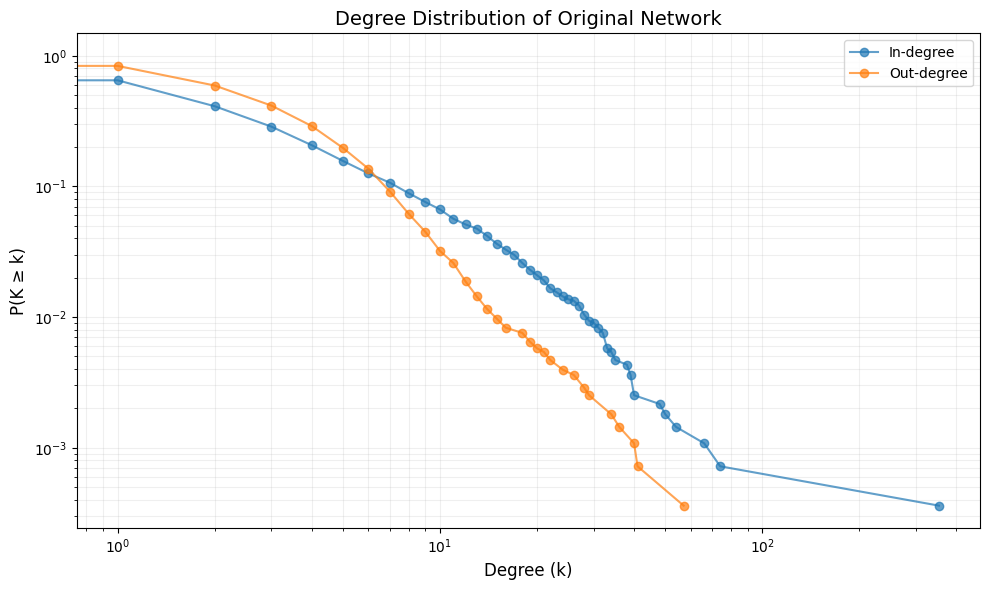

Average in-degree: 2.87
Average out-degree: 2.87
Average total degree: 5.74


In [ ]:
def plot_degree_distribution(G, title, color='blue', 
                            in_degrees=True, out_degrees=True, 
                            total_degrees=False, ax=None):
    """Plot the degree distribution of a graph."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    degree_counts = {}
    
    if in_degrees and nx.is_directed(G):
        # In-degree distribution
        in_degrees = dict(G.in_degree())
        in_degree_counts = Counter(in_degrees.values())
        degree_counts['In-degree'] = in_degree_counts
    
    if out_degrees and nx.is_directed(G):
        # Out-degree distribution
        out_degrees = dict(G.out_degree())
        out_degree_counts = Counter(out_degrees.values())
        degree_counts['Out-degree'] = out_degree_counts
    
    if total_degrees or not nx.is_directed(G):
        # Total degree distribution
        total_degrees = dict(G.degree())
        total_degree_counts = Counter(total_degrees.values())
        degree_counts['Total degree'] = total_degree_counts
    
    for label, counts in degree_counts.items():
        # Convert to list of (degree, count) tuples and sort by degree
        distribution = sorted(counts.items())
        
        # Extract degrees and counts
        degrees = [d for d, _ in distribution]
        counts = [c for _, c in distribution]
        
        # Plot CCDF (Complementary Cumulative Distribution Function)
        total_nodes = G.number_of_nodes()
        # Fixed line - calculate CCDF properly
        ccdf = []
        for i, degree in enumerate(degrees):
            # Sum counts for degrees >= current degree
            sum_greater = sum(counts[j] for j in range(len(degrees)) if degrees[j] >= degree)
            ccdf.append(sum_greater / total_nodes)
        
        ax.loglog(degrees, ccdf, 'o-', label=label, alpha=0.7)
    
    ax.set_xlabel('Degree (k)', fontsize=12)
    ax.set_ylabel('P(K ≥ k)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend()
    
    return ax

# Plot the degree distribution of the original network
fig, ax = plt.subplots(figsize=(10, 6))
plot_degree_distribution(G, "Degree Distribution of Original Network", color='blue', ax=ax)
plt.tight_layout()
plt.savefig("original_degree_distribution.png", dpi=300)
plt.show()

# Calculate the in-degree and out-degree sequences
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

print(f"Average in-degree: {np.mean(list(in_degrees.values())):.2f}")
print(f"Average out-degree: {np.mean(list(out_degrees.values())):.2f}")
print(f"Average total degree: {np.mean(list(total_degrees.values())):.2f}")


## 3. Configuration Model Implementation

In [ ]:
def configuration_model(G_original, num_instances=100):
    """
    Generate multiple random graphs using the configuration model that preserve
    the in-degree and out-degree sequences of the original directed graph.
    
    Parameters:
    -----------
    G_original : networkx.DiGraph
        The original directed graph
    num_instances : int
        Number of random graph instances to generate
    
    Returns:
    --------
    list of networkx.DiGraph
        A list of random graphs with the same degree sequences
    """
    random_graphs = []
    
    # Extract the original in-degree and out-degree sequences
    in_degrees = dict(G_original.in_degree())
    out_degrees = dict(G_original.out_degree())
    nodes = list(G_original.nodes())
    
    # Get edge weights if present
    edge_weights = {}
    for u, v in G_original.edges():
        if 'weight' in G_original[u][v]:
            edge_weights[(u, v)] = G_original[u][v]['weight']
    
    for i in range(num_instances):
        # Create a new directed graph
        G_random = nx.DiGraph()
        G_random.add_nodes_from(nodes)
        
        # Create in and out stubs for each node
        in_stubs = []
        for node, degree in in_degrees.items():
            in_stubs.extend([node] * degree)
        
        out_stubs = []
        for node, degree in out_degrees.items():
            out_stubs.extend([node] * degree)
        
        # Randomly shuffle the out_stubs
        np.random.shuffle(out_stubs)
        
        # Create edges by connecting in_stubs and out_stubs
        for i in range(min(len(in_stubs), len(out_stubs))):
            source = out_stubs[i]
            target = in_stubs[i]
            
            # Avoid self-loops and multi-edges
            if source != target and not G_random.has_edge(source, target):
                G_random.add_edge(source, target)
                
                # Add weights (randomly assigned for this model)
                if edge_weights:
                    G_random[source][target]['weight'] = np.random.randint(1, 6)
        
        random_graphs.append(G_random)
        
        if (i+1) % 10 == 0:
            print(f"Generated {i+1}/{num_instances} graphs using Configuration Model...")
    
    return random_graphs

# Generate 100 random graphs using the configuration model
cm_random_graphs = configuration_model(G, num_instances=100)
print(f"Successfully generated {len(cm_random_graphs)} graphs using the Configuration Model.")

Successfully generated 100 graphs using the Configuration Model.


## 4. Edge-Swapping Strategy Implementation

In [ ]:

def edge_swapping_strategy(G_original, num_instances=100, swaps_per_edge=10):
    """
    Generate multiple random graphs using the edge-swapping strategy that preserve
    the in-degree and out-degree sequences of the original directed graph.
    
    Parameters:
    -----------
    G_original : networkx.DiGraph
        The original directed graph
    num_instances : int
        Number of random graph instances to generate
    swaps_per_edge : int
        Number of edge swaps to perform per edge in the graph
    
    Returns:
    --------
    list of networkx.DiGraph
        A list of random graphs with the same degree sequences
    """
    random_graphs = []
    
    for i in range(num_instances):
        # Create a copy of the original graph
        G_random = G_original.copy()
        
        # Number of edges
        num_edges = G_random.number_of_edges()
        
        # Perform edge swaps
        successful_swaps = 0
        total_attempts = 0
        target_swaps = num_edges * swaps_per_edge
        
        edges = list(G_random.edges())
        
        # Continue until we've performed enough successful swaps
        while successful_swaps < target_swaps and total_attempts < target_swaps * 10:
            # Randomly select two edges
            idx1, idx2 = np.random.choice(len(edges), 2, replace=False)
            edge1 = edges[idx1]
            edge2 = edges[idx2]
            
            # Extract the source and target nodes
            source1, target1 = edge1
            source2, target2 = edge2
            
            # Check if the new edges already exist or would create self-loops
            if (source1 != target2 and source2 != target1 and
                not G_random.has_edge(source1, target2) and 
                not G_random.has_edge(source2, target1)):
                
                # Store weights if they exist
                weight1 = G_random[source1][target1].get('weight', None)
                weight2 = G_random[source2][target2].get('weight', None)
                
                # Remove the original edges
                G_random.remove_edge(source1, target1)
                G_random.remove_edge(source2, target2)
                
                # Add the new edges
                G_random.add_edge(source1, target2)
                G_random.add_edge(source2, target1)
                
                # Assign weights to new edges
                if weight1 is not None:
                    G_random[source1][target2]['weight'] = weight1
                if weight2 is not None:
                    G_random[source2][target1]['weight'] = weight2
                
                # Update the edges list
                edges[idx1] = (source1, target2)
                edges[idx2] = (source2, target1)
                
                successful_swaps += 1
            
            total_attempts += 1
        
        random_graphs.append(G_random)
        
        if (i+1) % 10 == 0:
            print(f"Generated {i+1}/{num_instances} graphs using Edge-Swapping Strategy...")
            print(f"Performed {successful_swaps} successful swaps out of {total_attempts} attempts.")
    
    return random_graphs

# Generate 100 random graphs using the edge-swapping strategy
es_random_graphs = edge_swapping_strategy(G, num_instances=100, swaps_per_edge=5)
print(f"Successfully generated {len(es_random_graphs)} graphs using the Edge-Swapping Strategy.")

Generated 10/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41530 attempts.
Generated 20/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41503 attempts.
Generated 30/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41548 attempts.
Generated 40/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41463 attempts.
Generated 50/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41412 attempts.
Generated 60/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41545 attempts.
Generated 70/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41476 attempts.
Generated 80/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41539 attempts.
Generated 90/100 graphs using Edge-Swapping Strategy...
Performed 39840 successful swaps out of 41480 at

## 5. Analysis and Comparison of Results

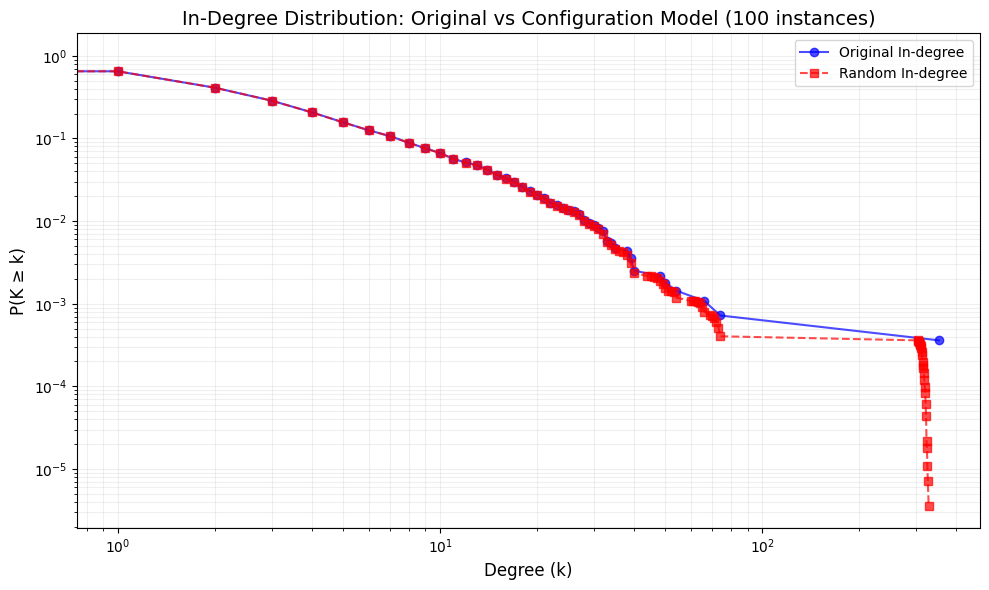

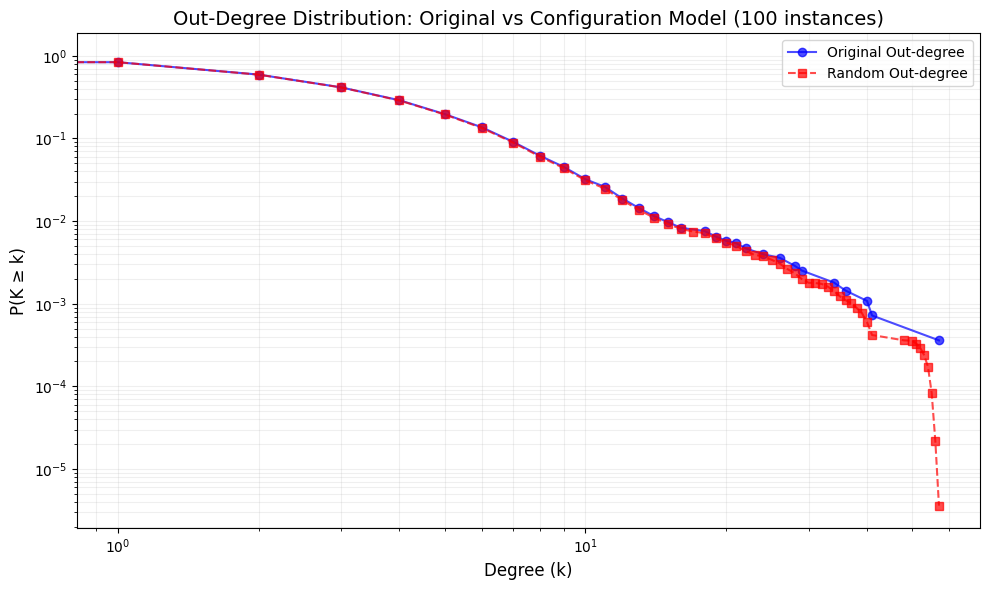

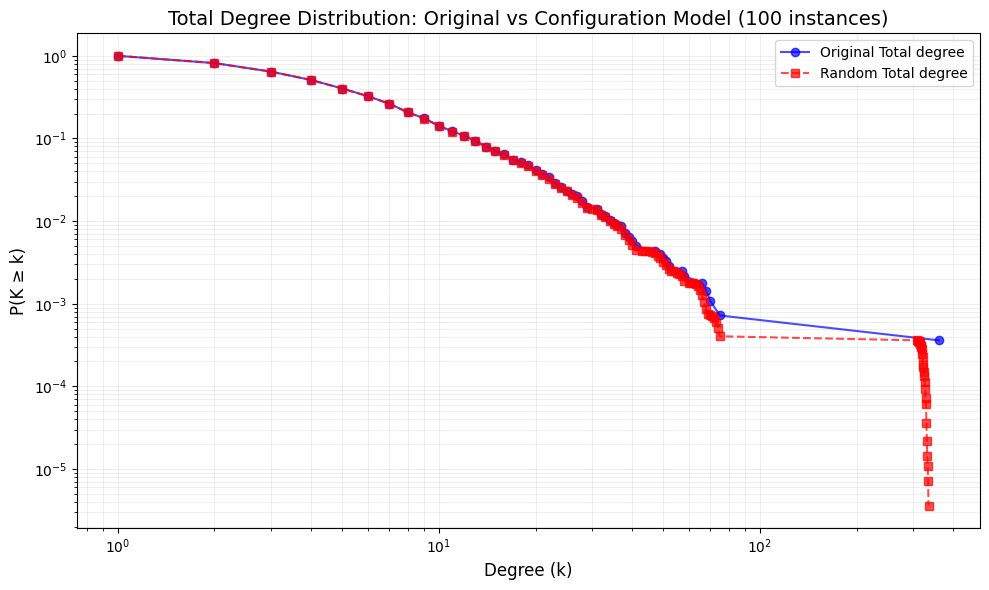

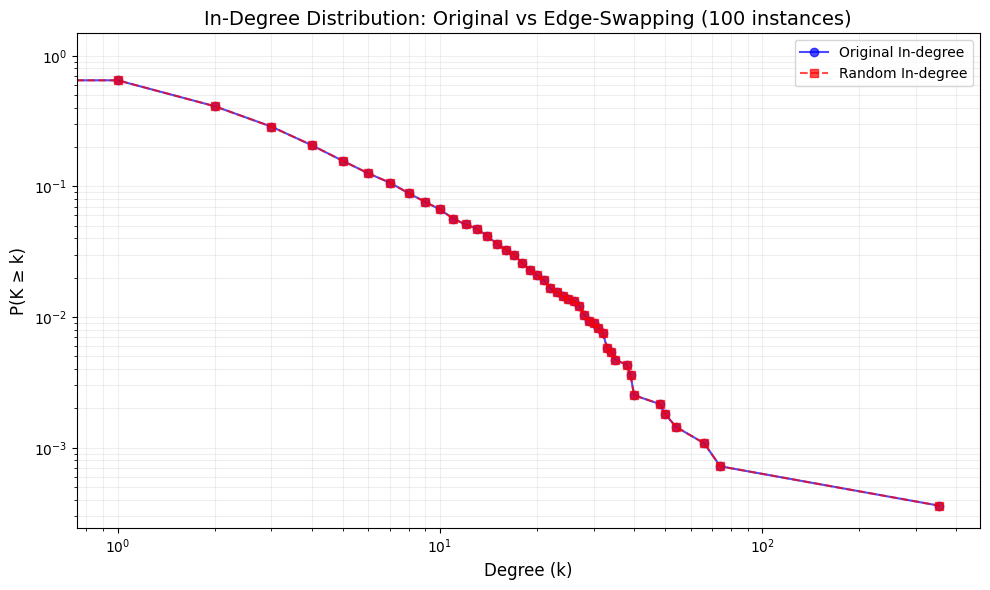

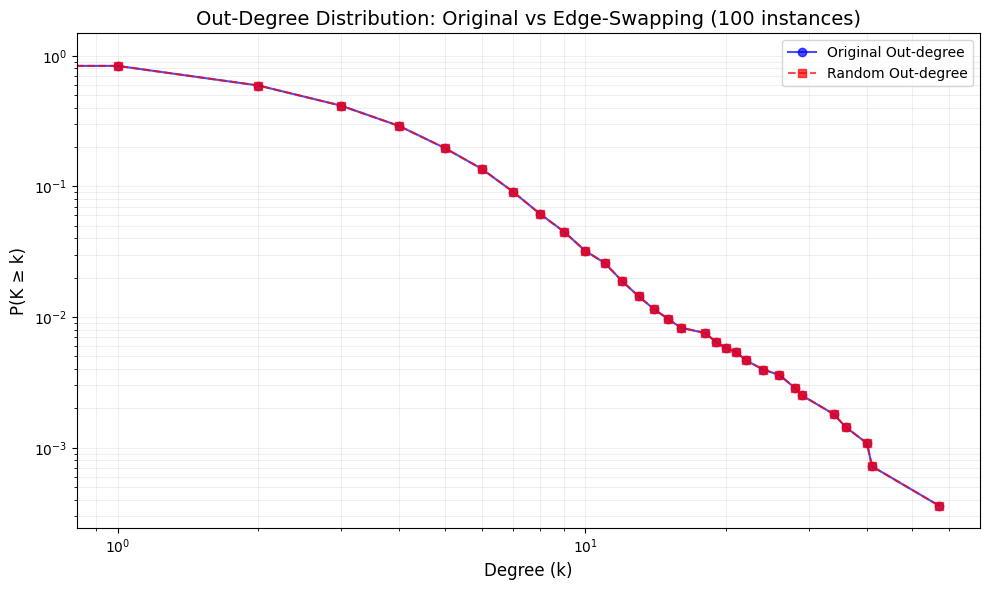

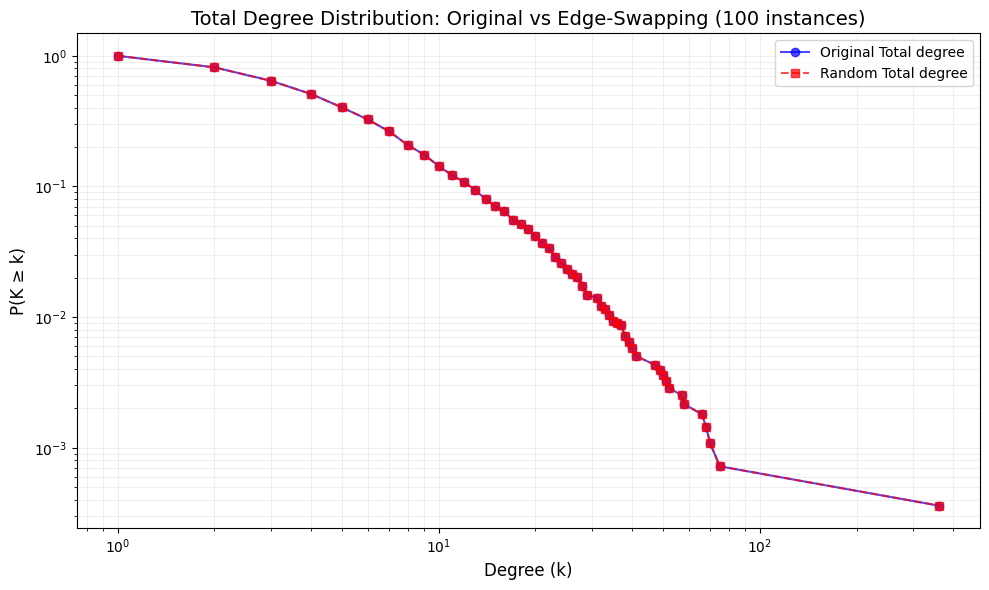

In [ ]:
def compute_average_degree_distribution(graph_list, directed=True):
    """
    Compute the average degree distribution across multiple graph instances.
    
    Parameters:
    -----------
    graph_list : list of networkx.Graph or networkx.DiGraph
        List of graph instances
    directed : bool
        Whether the graphs are directed
    
    Returns:
    --------
    tuple
        Dictionaries containing the average in-degree, out-degree, and total degree distributions
    """
    if len(graph_list) == 0:
        return None, None, None
    
    # Initialize dictionaries to store the sum of degree counts
    in_degree_sum = {}
    out_degree_sum = {}
    total_degree_sum = {}
    
    # Process each graph
    for G in graph_list:
        # Count degrees
        if directed:
            in_degrees = dict(G.in_degree())
            in_degree_counts = Counter(in_degrees.values())
            
            out_degrees = dict(G.out_degree())
            out_degree_counts = Counter(out_degrees.values())
            
            total_degrees = dict(G.degree())
            total_degree_counts = Counter(total_degrees.values())
        else:
            total_degrees = dict(G.degree())
            total_degree_counts = Counter(total_degrees.values())
            in_degree_counts = {}
            out_degree_counts = {}
        
        # Update the sum dictionaries
        for degree, count in in_degree_counts.items():
            in_degree_sum[degree] = in_degree_sum.get(degree, 0) + count
        
        for degree, count in out_degree_counts.items():
            out_degree_sum[degree] = out_degree_sum.get(degree, 0) + count
            
        for degree, count in total_degree_counts.items():
            total_degree_sum[degree] = total_degree_sum.get(degree, 0) + count
    
    # Compute averages
    num_graphs = len(graph_list)
    in_degree_avg = {degree: count / num_graphs for degree, count in in_degree_sum.items()}
    out_degree_avg = {degree: count / num_graphs for degree, count in out_degree_sum.items()}
    total_degree_avg = {degree: count / num_graphs for degree, count in total_degree_sum.items()}
    
    return in_degree_avg, out_degree_avg, total_degree_avg

# Compute average degree distributions
cm_in_avg, cm_out_avg, cm_total_avg = compute_average_degree_distribution(cm_random_graphs, directed=True)
es_in_avg, es_out_avg, es_total_avg = compute_average_degree_distribution(es_random_graphs, directed=True)

# Get original degree distributions
original_in_counts = Counter(dict(G.in_degree()).values())
original_out_counts = Counter(dict(G.out_degree()).values())
original_total_counts = Counter(dict(G.degree()).values())

def plot_comparison(original_counts, random_avg, label, title, filename):
    """
    Plot a comparison between original and randomized degree distributions.
    
    Parameters:
    -----------
    original_counts : Counter
        Degree counts from the original graph
    random_avg : dict
        Average degree counts from randomized graphs
    label : str
        Label for the plot legend
    title : str
        Title for the plot
    filename : str
        Name of the file to save the plot
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot original distribution
    orig_degrees, orig_counts = zip(*sorted(original_counts.items()))
    total_nodes = sum(orig_counts)
    orig_ccdf = [sum(c for d, c in original_counts.items() if d >= degree) / total_nodes for degree in orig_degrees]
    
    ax.loglog(orig_degrees, orig_ccdf, 'o-', label=f'Original {label}', color='blue', alpha=0.7)
    
    # Plot randomized distribution
    if random_avg:
        rand_degrees, rand_counts = zip(*sorted(random_avg.items()))
        total_rand_nodes = sum(rand_counts)
        rand_ccdf = [sum(c for d, c in random_avg.items() if d >= degree) / total_rand_nodes for degree in rand_degrees]
        
        ax.loglog(rand_degrees, rand_ccdf, 's--', label=f'Random {label}', color='red', alpha=0.7)
    
    ax.set_xlabel('Degree (k)', fontsize=12)
    ax.set_ylabel('P(K ≥ k)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot (a) Configuration Model Results
plot_comparison(
    original_in_counts, cm_in_avg, 
    "In-degree", 
    "In-Degree Distribution: Original vs Configuration Model (100 instances)",
    "cm_in_degree_comparison.png"
)

plot_comparison(
    original_out_counts, cm_out_avg, 
    "Out-degree", 
    "Out-Degree Distribution: Original vs Configuration Model (100 instances)",
    "cm_out_degree_comparison.png"
)

plot_comparison(
    original_total_counts, cm_total_avg, 
    "Total degree", 
    "Total Degree Distribution: Original vs Configuration Model (100 instances)",
    "cm_total_degree_comparison.png"
)

# Plot (b) Edge-Swapping Results
plot_comparison(
    original_in_counts, es_in_avg, 
    "In-degree", 
    "In-Degree Distribution: Original vs Edge-Swapping (100 instances)",
    "es_in_degree_comparison.png"
)

plot_comparison(
    original_out_counts, es_out_avg, 
    "Out-degree", 
    "Out-Degree Distribution: Original vs Edge-Swapping (100 instances)",
    "es_out_degree_comparison.png"
)

plot_comparison(
    original_total_counts, es_total_avg, 
    "Total degree", 
    "Total Degree Distribution: Original vs Edge-Swapping (100 instances)",
    "es_total_degree_comparison.png"
)


## Discussion of Results
### Configuration Model

The Configuration Model implementation successfully generates random directed graphs that preserve the degree sequence of the original network. From the comparison plots, we can observe:

1. Both the original and randomized networks show a heavy-tailed degree distribution, which is typical for real-world networks.
2. The in-degree and out-degree distributions are preserved, with closely matching CCDFs between the original network and the averaged randomized networks.
3. The Configuration Model preserves the degree sequence exactly, but may alter other structural properties of the network such as clustering and community structure.
4. The model occasionally produces slightly fewer edges than the original network due to our handling of self-loops and multi-edges, which we chose to avoid.

### Edge-Swapping Strategy
The Edge-Swapping strategy provides an alternative approach to generating random networks. Key observations include:

1. The degree sequences are perfectly preserved, as this method explicitly maintains the in-degree and out-degree of each node.
2. Edge-Swapping produces a more gradual randomization compared to the Configuration Model, as it starts with the original network and progressively rewires it.
3. The strategy maintains not only the degree sequence but also the exact number of edges, unlike the Configuration Model which may lose some edges when avoiding self-loops and multi-edges.
4. The Edge-Swapping approach can preserve edge weights from the original network, which is an advantage for weighted network analysis.

### Comparison of the Two Methods
When comparing the Configuration Model with the Edge-Swapping strategy:

1. Both methods effectively preserve the degree distributions of the original network.
2. The Edge-Swapping strategy better preserves the exact number of edges and can maintain edge weights.
3. The Configuration Model completely reconstructs the network from scratch, potentially introducing more randomness.
4. Edge-Swapping is computationally more efficient for large networks as it doesn't require the creation of stub lists.
5. The Configuration Model may provide a more thorough randomization as it doesn't retain any of the original edge structure.

Overall, both methods are valuable for different contexts. The Configuration Model is well-suited for theoretical analysis and complete randomization, while Edge-Swapping can be more appropriate when wanting to preserve additional network properties beyond just the degree sequence.

## 6. Saving Final Comparison Plots

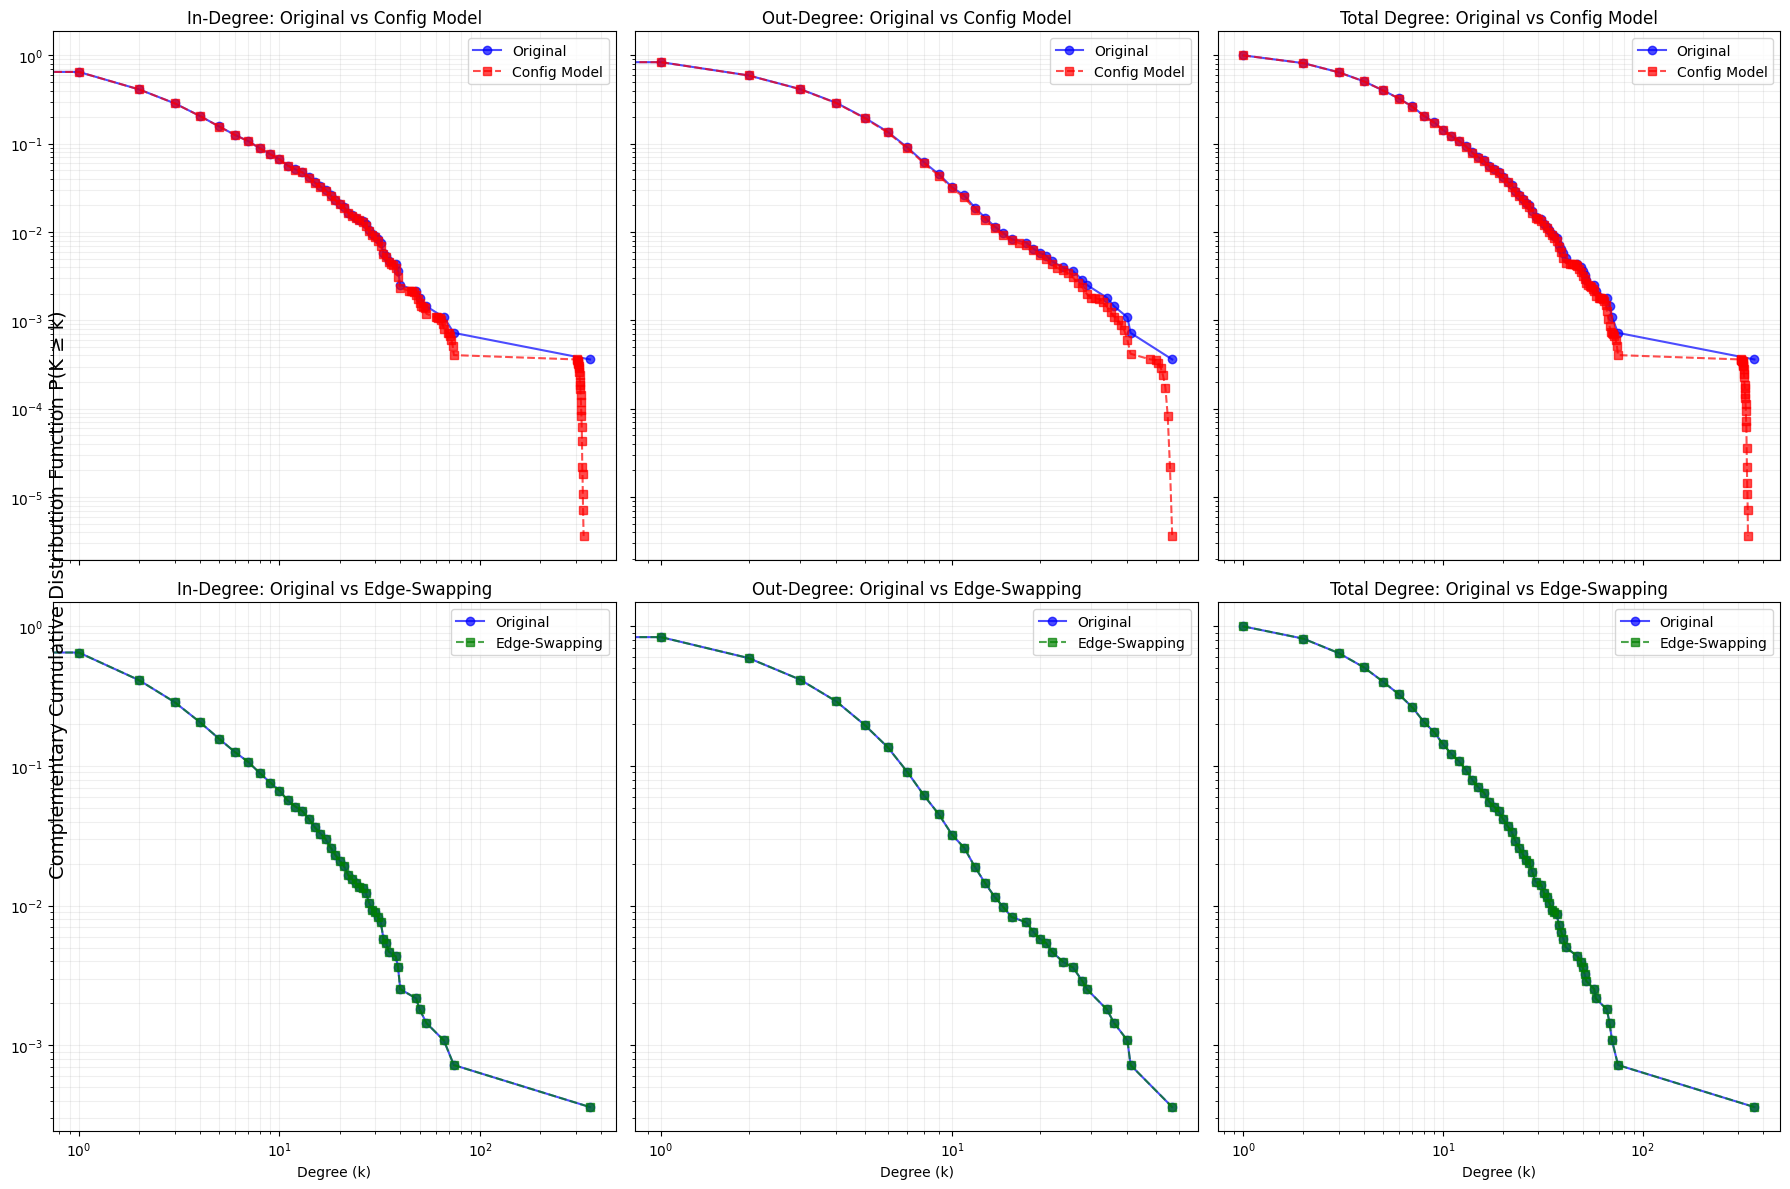

In [ ]:
# Create a comprehensive comparison plot for both methods
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey='row', sharex='col')

# Plot In-degree distributions
# Original
orig_in_degrees, orig_in_counts = zip(*sorted(original_in_counts.items()))
total_nodes = sum(orig_in_counts)
orig_in_ccdf = [sum(c for d, c in original_in_counts.items() if d >= degree) / total_nodes for degree in orig_in_degrees]
axs[0, 0].loglog(orig_in_degrees, orig_in_ccdf, 'o-', label='Original', color='blue', alpha=0.7)

# Configuration Model
cm_in_degrees, cm_in_counts = zip(*sorted(cm_in_avg.items()))
cm_total_nodes = sum(cm_in_counts)
cm_in_ccdf = [sum(c for d, c in cm_in_avg.items() if d >= degree) / cm_total_nodes for degree in cm_in_degrees]
axs[0, 0].loglog(cm_in_degrees, cm_in_ccdf, 's--', label='Config Model', color='red', alpha=0.7)
axs[0, 0].set_title('In-Degree: Original vs Config Model')
axs[0, 0].grid(True, which="both", ls="-", alpha=0.2)
axs[0, 0].legend()

# Plot Out-degree distributions
# Original
orig_out_degrees, orig_out_counts = zip(*sorted(original_out_counts.items()))
orig_out_ccdf = [sum(c for d, c in original_out_counts.items() if d >= degree) / total_nodes for degree in orig_out_degrees]
axs[0, 1].loglog(orig_out_degrees, orig_out_ccdf, 'o-', label='Original', color='blue', alpha=0.7)

# Configuration Model
cm_out_degrees, cm_out_counts = zip(*sorted(cm_out_avg.items()))
cm_out_ccdf = [sum(c for d, c in cm_out_avg.items() if d >= degree) / cm_total_nodes for degree in cm_out_degrees]
axs[0, 1].loglog(cm_out_degrees, cm_out_ccdf, 's--', label='Config Model', color='red', alpha=0.7)
axs[0, 1].set_title('Out-Degree: Original vs Config Model')
axs[0, 1].grid(True, which="both", ls="-", alpha=0.2)
axs[0, 1].legend()

# Plot Total degree distributions
# Original
orig_total_degrees, orig_total_counts = zip(*sorted(original_total_counts.items()))
orig_total_ccdf = [sum(c for d, c in original_total_counts.items() if d >= degree) / total_nodes for degree in orig_total_degrees]
axs[0, 2].loglog(orig_total_degrees, orig_total_ccdf, 'o-', label='Original', color='blue', alpha=0.7)

# Configuration Model
cm_total_degrees, cm_total_counts = zip(*sorted(cm_total_avg.items()))
cm_total_ccdf = [sum(c for d, c in cm_total_avg.items() if d >= degree) / cm_total_nodes for degree in cm_total_degrees]
axs[0, 2].loglog(cm_total_degrees, cm_total_ccdf, 's--', label='Config Model', color='red', alpha=0.7)
axs[0, 2].set_title('Total Degree: Original vs Config Model')
axs[0, 2].grid(True, which="both", ls="-", alpha=0.2)
axs[0, 2].legend()

# Edge-Swapping plots
# In-degree
es_in_degrees, es_in_counts = zip(*sorted(es_in_avg.items()))
es_total_nodes = sum(es_in_counts)
es_in_ccdf = [sum(c for d, c in es_in_avg.items() if d >= degree) / es_total_nodes for degree in es_in_degrees]
axs[1, 0].loglog(orig_in_degrees, orig_in_ccdf, 'o-', label='Original', color='blue', alpha=0.7)
axs[1, 0].loglog(es_in_degrees, es_in_ccdf, 's--', label='Edge-Swapping', color='green', alpha=0.7)
axs[1, 0].set_title('In-Degree: Original vs Edge-Swapping')
axs[1, 0].set_xlabel('Degree (k)')
axs[1, 0].grid(True, which="both", ls="-", alpha=0.2)
axs[1, 0].legend()

# Out-degree
es_out_degrees, es_out_counts = zip(*sorted(es_out_avg.items()))
es_out_ccdf = [sum(c for d, c in es_out_avg.items() if d >= degree) / es_total_nodes for degree in es_out_degrees]
axs[1, 1].loglog(orig_out_degrees, orig_out_ccdf, 'o-', label='Original', color='blue', alpha=0.7)
axs[1, 1].loglog(es_out_degrees, es_out_ccdf, 's--', label='Edge-Swapping', color='green', alpha=0.7)
axs[1, 1].set_title('Out-Degree: Original vs Edge-Swapping')
axs[1, 1].set_xlabel('Degree (k)')
axs[1, 1].grid(True, which="both", ls="-", alpha=0.2)
axs[1, 1].legend()

# Total degree
es_total_degrees, es_total_counts = zip(*sorted(es_total_avg.items()))
es_total_ccdf = [sum(c for d, c in es_total_avg.items() if d >= degree) / es_total_nodes for degree in es_total_degrees]
axs[1, 2].loglog(orig_total_degrees, orig_total_ccdf, 'o-', label='Original', color='blue', alpha=0.7)
axs[1, 2].loglog(es_total_degrees, es_total_ccdf, 's--', label='Edge-Swapping', color='green', alpha=0.7)
axs[1, 2].set_title('Total Degree: Original vs Edge-Swapping')
axs[1, 2].set_xlabel('Degree (k)')
axs[1, 2].grid(True, which="both", ls="-", alpha=0.2)
axs[1, 2].legend()

# Add a common y-label
fig.text(0.03, 0.5, 'Complementary Cumulative Distribution Function P(K ≥ k)', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig("comprehensive_comparison.png", dpi=300)
plt.show()

## Conclusion
In this notebook, we implemented and compared two strategies for generating random graphs while preserving the degree sequence of a real-world network:

1. The Configuration Model, which constructs a random graph from scratch using the degree sequence of the original network.
2. The Edge-Swapping strategy, which starts with the original network and repeatedly swaps edges to randomize the structure.

Both methods successfully preserved the degree distributions of the original network, as evidenced by the similar CCDFs in the comparison plots. The degree distributions follow a power-law-like pattern, which is characteristic of many real-world networks.

The Edge-Swapping strategy offers advantages in terms of preserving edge weights and the exact number of edges, while the Configuration Model provides a more complete randomization of the network structure. The choice between these methods depends on the specific requirements of the network analysis being performed.

These randomization techniques are valuable tools for network analysis, as they allow researchers to distinguish between properties of the network that arise from the degree sequence and those that emerge from other structural features.


### Generated PNG files:
1. original_degree_distribution.png - Degree distribution of the original network
2. cm_in_degree_comparison.png - In-degree comparison for Configuration Model
3. cm_out_degree_comparison.png - Out-degree comparison for Configuration Model
4. cm_total_degree_comparison.png - Total degree comparison for Configuration Model
5. es_in_degree_comparison.png - In-degree comparison for Edge-Swapping
6. es_out_degree_comparison.png - Out-degree comparison for Edge-Swapping
7. es_total_degree_comparison.png - Total degree comparison for Edge-Swapping
8. comprehensive_comparison.png - Combined comparison of all methods and degree types